# About different data same box plot

- toc: true 
- badges: true
- comments: false
- categories: [r,ggplot,recipes]


*TOC*
* write a function for generating random  group of data with (almost) same stats


 



As in my previous [post](https://jojosgithub.github.io/blog/r/ggplot/recipes/2021/06/18/boxplot.html)  I was fascinated by the "datasaurus" (sets of data having same basic stats and also same boxplot). You can have a  look at this [page](https://www.autodesk.com/research/publications/same-stats-different-graphs) to find all details. Since the plot also looks a lot like a kind of diffraction pattern I tried a simple idea I had in mind. **What will happen if I generate distributions with as mean the median, q1,q3,min and max of a "reference" dataset and I merge everything together?**
If I keep the everything "symmetric enough" (I know this is a term that does not exists) cuttin in half the distibution at the min and max I probably will obtain another "equivalent" dataset. 

In [21]:
library(data.table)
library(ggplot2)
library(datasauRus)
library(patchwork)
library(foreach)




summary(box_plots)

      left              lines               normal          right       
 Min.   :-9.76964   Min.   :-9.769575   Min.   :-9.76   Min.   :-9.760  
 1st Qu.:-2.68999   1st Qu.:-2.689993   1st Qu.:-2.68   1st Qu.:-2.680  
 Median :-0.00999   Median :-0.007132   Median : 0.00   Median : 0.000  
 Mean   :-1.17780   Mean   :-0.831733   Mean   : 0.00   Mean   : 1.174  
 3rd Qu.: 2.67007   3rd Qu.: 2.670236   3rd Qu.: 2.68   3rd Qu.: 2.680  
 Max.   : 9.75025   Max.   : 9.756001   Max.   : 9.76   Max.   : 9.760  
     split          
 Min.   :-9.769886  
 1st Qu.:-2.689989  
 Median :-0.003099  
 Mean   :-0.003060  
 3rd Qu.: 2.680000  
 Max.   : 9.760000  

# A simple start
Before creating a function with custom parameters we will start in the most simple way possible

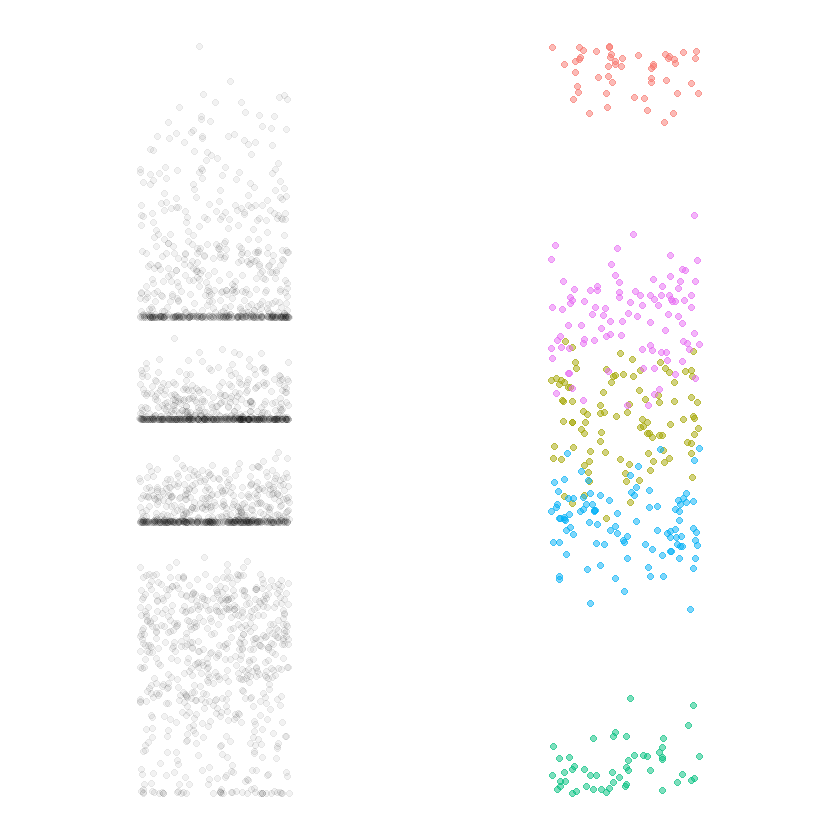

In [22]:
in_dat <- summary(box_plots$left)


median_r <- in_dat[3]
q1_r  <- in_dat[2]
q3_r  <- in_dat[5] 
min_r <- in_dat[1]
max_r <- in_dat[6]
sd_r <- abs(max_r-min_r)/20

npoints=100

d_median <- rnorm(npoints,median_r,sd_r)
d_q1 <- rnorm(npoints,q1_r,sd_r)
d_q3 <- rnorm(npoints,q3_r,sd_r)
d_min <- rnorm(npoints,min_r,sd_r)
d_max <- rnorm(npoints,max_r,sd_r)
sim      <- c(d_median,d_q1,d_q3,d_min,d_max)

lab_median <- rep("median",npoints)
lab_q1     <- rep("q1"    ,npoints)
lab_q3     <- rep("q3"    ,npoints)
lab_min     <- rep("min"  ,npoints)
lab_max     <- rep("max"  ,npoints)

sim_lab <- c(lab_median,lab_q1,lab_q3,lab_min,lab_max)
df_sim <- data.frame(sim,sim_lab)
df_sim_sel <- df_sim[df_sim$sim < max_r & df_sim$sim>min_r,]



psim <-ggplot(df_sim_sel, aes(x = 0, y = sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							     +
       theme_void()                                          + 
       theme(legend.position = "none")                       +
	   xlim(-1, 1)

bplot <- data.frame(box_plots)
p1 <-ggplot(bplot, aes(x = 0, y = left))                   +
     geom_jitter(alpha=0.05)							   +
     theme_void()                                          + 
     theme(legend.position = "none")                       +
	 xlim(-1, 1)
	   
#summary(df_sim_sel$sim)

p1 + psim 

so the plot is almost there but the data are still _not ok_ now we create a function, add points and create a bit of benchmarks and also plots.starting with the function


In [23]:

boxSim <- function(npoints,med = median_r,
				   q1 = q1_r,
				   q3 = q3_r,
				   mmin = min_r,
				   mmax = max_r,
				   sdr = c(2,2,2,2,2))
{

d_median <- rnorm(npoints,med,sdr[1])
d_q1 <- rnorm(npoints,q1,sdr[2])
d_q3 <- rnorm(npoints,q3,sdr[3])
d_min <- rnorm(npoints,mmin,sdr[4])
d_max <- rnorm(npoints,mmax,sdr[5])

sim      <- c(d_median,d_q1,d_q3,d_min,d_max)

lab_median <- rep("median",npoints)
lab_q1     <- rep("q1"    ,npoints)
lab_q3     <- rep("q3"    ,npoints)
lab_min     <- rep("min"  ,npoints)
lab_max     <- rep("max"  ,npoints)

sim_lab <- c(lab_median,lab_q1,lab_q3,lab_min,lab_max)
df_sim <- data.frame(sim,sim_lab)
df_sim_sel <- df_sim[df_sim$sim < mmax & df_sim$sim>mmin,]

return(df_sim_sel)
}


now everything is more flexible since we can give each of the `median`,`q1`,`q3`,`min`,`max` its own variance and create 
even more combinations (keeping "everything symmetric")


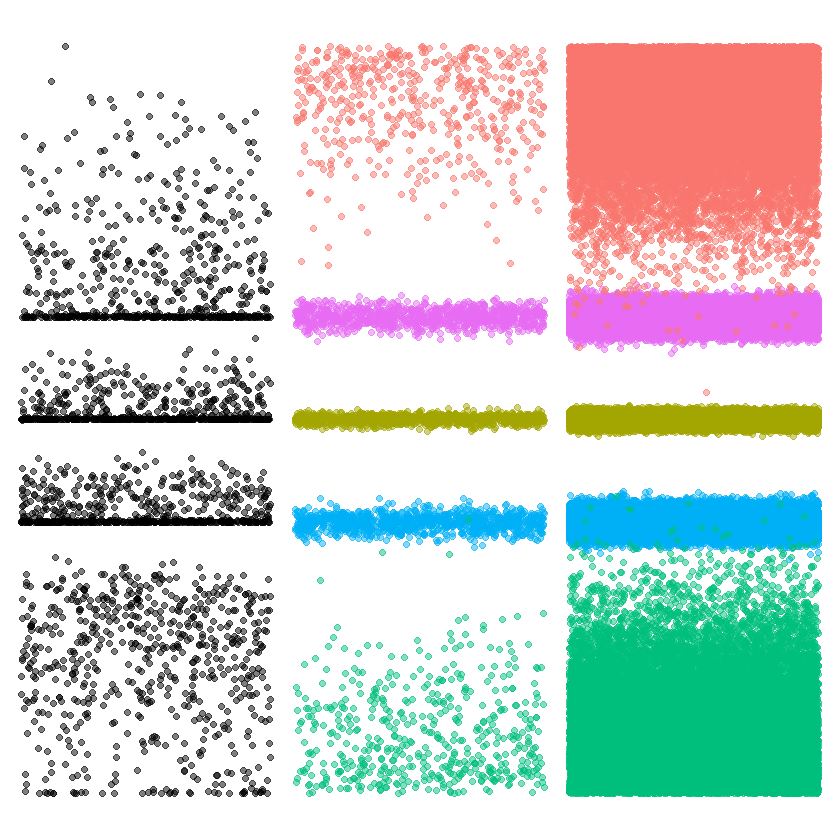

In [24]:
#our imput data
median_r <- in_dat[3]
q1_r  <- in_dat[2]
q3_r  <- in_dat[5] 
min_r <- in_dat[1]
max_r <- in_dat[6]
sd_r <- abs(max_r-min_r)/10

n_points = c(100,1000,50000)

t100 <- boxSim(100,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.1,0.2,0.2,2,2))
t1k  <- boxSim(1000,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.1,0.2,0.2,2,2))
t50k  <- boxSim(50000,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.1,0.2,0.2,2,2))

t100_2 <- boxSim(100,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.2,0.2,0.2,3,3))
t1k_2  <- boxSim(1000,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.2,0.2,0.2,3,3))
t50k_2 <- boxSim(50000,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.2,0.2,0.2,3,3))

ptest <-ggplot(t100, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   xlim(-1, 3)

legend <- cowplot::get_legend(ptest)	  

datr <- data.table(box_plots$left)
colnames(datr) <- c("y")

pref <-  ggplot(datr, aes(x = 1, y = y )) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

pt100 <-ggplot(t100, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

pt1k <-ggplot(t1k, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")
	   
pt50k <-ggplot(t50k, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

pt100_2 <-ggplot(t100_2, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

pt1k_2 <-ggplot(t1k_2, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")
	   
pt5k_2 <-ggplot(t50k_2, aes(x = 1, y =sim, color=sim_lab)) +
	   geom_jitter(alpha=0.5)							+
       theme_void() +
	   theme(legend.position = "none")

library(patchwork)

pref + pt1k + pt50k



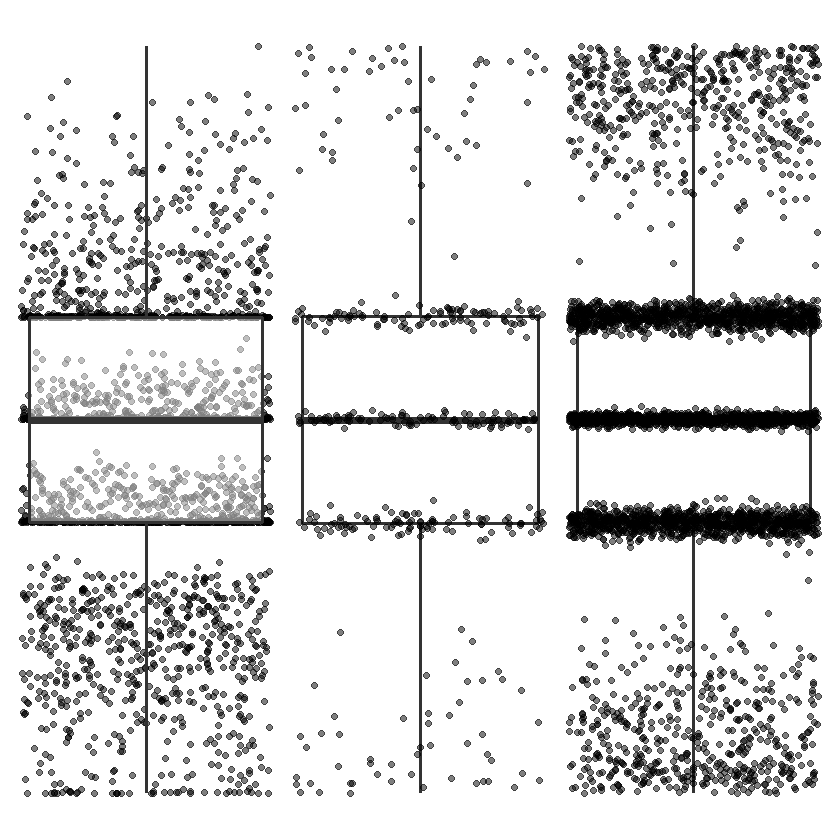

In [25]:
pb1 <- pref + geom_boxplot(lwd=1, alpha=0.5) 
pb2 <- ggplot(t100, aes(x = 1, y =sim)) + geom_boxplot(lwd=1) + geom_jitter(alpha=0.5) + theme_void() +
       theme(legend.position = "none")
pb3 <- ggplot(t1k, aes(x = 1, y =sim)) + geom_boxplot(lwd=1) + geom_jitter(alpha=0.5) + theme_void() +
       theme(legend.position = "none")

pb1+pb2+pb3

In [26]:
refdf <- data.frame(unclass(summary(datr)))
colnames(refdf) <- ("refdf")

library(foreach)

test <- foreach(i=seq(1000,20000,5000)) %do% boxSim(i,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.1,0.2,0.2,2,2))
res <- lapply(seq(1,length(test)), function(x) summary(test[[x]]$sim))
res <- lapply(seq(1,length(test)), function(x) data.frame(unclass(summary(test[[x]]$sim)), check.names = FALSE, stringsAsFactors = FALSE) )
res.dat <- data.frame(res)
              
colnames(res.dat) <- as.character(paste0("npoints_",seq(1000,20000,5000)))

r1 <- data.frame(refdf,res.dat)

test2 <- foreach(i=seq(1000,20000,5000)) %do% boxSim(i,in_dat[3],in_dat[2], in_dat[5],in_dat[1],in_dat[6],c(0.2,0.2,0.2,3,3))
res2 <- lapply(seq(1,length(test)), function(x) summary(test[[x]]$sim))
res2 <- lapply(seq(1,length(test)), function(x) data.frame(unclass(summary(test2[[x]]$sim)), check.names = FALSE, stringsAsFactors = FALSE) )
res2.dat <- data.frame(res2)
colnames(res2.dat) <- as.character(paste0("npoints_",seq(1000,20000,5000)))

r2 <- data.frame(refdf,res.dat)

r1
r2
 

,refdf,npoints_1000,npoints_6000,npoints_11000,npoints_16000
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
X,Min. :-9.76964,-9.767939026,-9.768614806,-9.769298285,-9.769536232
X.1,1st Qu.:-2.68999,-2.686217045,-2.685360329,-2.687121153,-2.690590714
X.2,Median :-0.00999,-0.004413976,-0.009276465,-0.007803756,-0.009258504
X.3,Mean :-1.17780,0.044155044,0.020435948,0.015923968,-0.011980299
X.4,3rd Qu.: 2.67007,2.687758705,2.674296672,2.674702199,2.670794407
X.5,Max. : 9.75025,9.750220137,9.748054852,9.749136200,9.750197901


,refdf,npoints_1000,npoints_6000,npoints_11000,npoints_16000
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
X,Min. :-9.76964,-9.767939026,-9.768614806,-9.769298285,-9.769536232
X.1,1st Qu.:-2.68999,-2.686217045,-2.685360329,-2.687121153,-2.690590714
X.2,Median :-0.00999,-0.004413976,-0.009276465,-0.007803756,-0.009258504
X.3,Mean :-1.17780,0.044155044,0.020435948,0.015923968,-0.011980299
X.4,3rd Qu.: 2.67007,2.687758705,2.674296672,2.674702199,2.670794407
X.5,Max. : 9.75025,9.750220137,9.748054852,9.749136200,9.750197901


with this very brutal test we can see that *1000 points are enough to obtain an acceptable random dataset with predefined stats*.
Also the fun is that changing seeds everytime we have a different dataset.so the mainly advantages are
- extremely fast
- can generate dataset with same stats as a reference dataset (the generated set can have same number of points > or <)
- can several kind of distributions (need to keep data "symmetry")
Probably also this can be a starting point for applying a simulated annealing after. Or this very simple stragegy can be employed for other problems.